Data from https://www.kaggle.com/alopez247/pokemon

In [1]:
%matplotlib inline

import warnings

import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from node2vec import Node2Vec

warnings.filterwarnings('ignore')

C:\Users\Elbert\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Data loading, preprocessing

In [2]:
data_path = './data/pokemon_alopez247.csv'

In [3]:
# keep only columns that would be relevant to battles (and color for visualization)
cols = ['Name', 'Type_1', 'Type_2', 'Total', 'HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'isLegendary', 'Color', 'hasMegaEvolution']
data = pd.read_csv(data_path, usecols=cols)
data['Type_2'].fillna('', inplace=True)

data.head()

,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,isLegendary,Color,hasMegaEvolution
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,False,Green,False
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,False,Green,False
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,False,Green,True
3,Charmander,Fire,,309,39,52,43,60,50,65,False,Red,False
4,Charmeleon,Fire,,405,58,64,58,80,65,80,False,Red,False


Create graphs for each Pokemon

In [4]:
graph = nx.Graph()

for _, pokemon in data.iterrows():
    name = pokemon['Name']
    graph.add_edge(name, pokemon['Type_1'])
    if not pokemon['Type_2']:
        graph.add_edge(name, pokemon['Type_2'])
    graph.add_edge(name, pokemon['Total'])
    graph.add_edge(name, pokemon['HP'])
    graph.add_edge(name, pokemon['Attack'])
    graph.add_edge(name, pokemon['Defense'])
    graph.add_edge(name, pokemon['Sp_Atk'])
    graph.add_edge(name, pokemon['Sp_Def'])
    graph.add_edge(name, pokemon['Speed'])
    if pokemon['isLegendary']:
        graph.add_edge(name, 'Legendary')
    if pokemon['hasMegaEvolution']:
        graph.add_edge(name, 'Mega')

Run Node2Vec

In [5]:
# TODO: tune hyperparameters
dimensions = 20
walk_length = 16
num_walks = 100
window = 10
min_count = 1

In [6]:
node2vec = Node2Vec(graph, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks)

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.63it/s]


In [7]:
model = node2vec.fit(window=window, min_count=min_count)

In [8]:
types = list(data['Type_2'].unique()) + ['Legendary', 'Mega']

for node, _ in model.wv.most_similar('Bulbasaur'):
    if not str.isdigit(node) and len(node) and node not in types:
        print(node)

Chikorita
Jumpluff
Exeggcute
Skiploom
Gloom
Nuzleaf
Roselia
Weepinbell
Cacnea


In [9]:
for node, _ in model.wv.most_similar('Charmander'):
    if not str.isdigit(node) and len(node) and node not in types:
        print(node)

Cyndaquil
Chimchar
Quilava
Charmeleon
Growlithe
Monferno
Combusken
Phantump
Magmar


In [10]:
for node, _ in model.wv.most_similar('Squirtle'):
    if not str.isdigit(node) and len(node) and node not in types:
        print(node)

Totodile
Corphish
Piplup
Panpour
Luvdisc
Tympole
Froakie
Clauncher
Psyduck


In [11]:
pokemon = [x for x in model.wv.vocab if not str.isdigit(x) and node not in types]
embeddings = np.array([model.wv[x] for x in pokemon])

In [12]:
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)

In [13]:
type_colors = {
    'Grass': '#8ED752',
    'Fire': '#F95643',
    'Water': '#53AFFE',
    'Bug': '#C3D221',
    'Normal': '#BBBDAF',
    'Poison': '#AD5CA2',
    'Electric': '#F8E64E',
    'Ground': '#F0CA42',
    'Fairy': '#F9AEFE',
    'Fighting': '#A35449',
    'Psychic': '#FB61B4',
    'Rock': '#CDBD72',
    'Ghost': '#7673DA',
    'Ice': '#66EBFF',
    'Dragon': '#8B76FF',
    'Dark': '#8E6856',
    'Steel': '#C3C1D7',
    'Flying': '#75A4F9'
}

data['Type_color'] = data['Type_1'].apply(lambda x: type_colors[x])

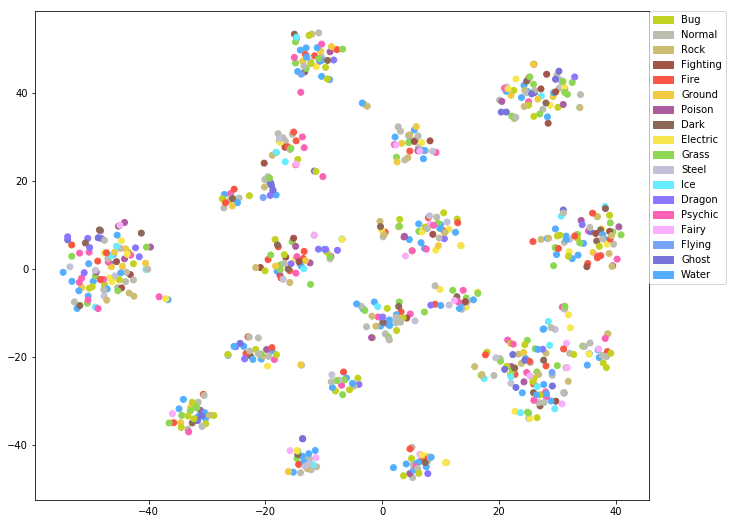

In [15]:
figure = plt.figure(figsize=(11, 9))
ax = figure.add_subplot(111)
ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=data['Type_color'])
type_patches = [mpatches.Patch(color=color, label=typ) for typ, color in type_colors.items()]
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., handles=type_patches);